In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
extractPath = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\INDA\\CDF-INDA'

In [4]:
import os
# List the files in the extracted directory
image_files = [f for f in os.listdir(extractPath) if os.path.isfile(os.path.join(extractPath, f))]

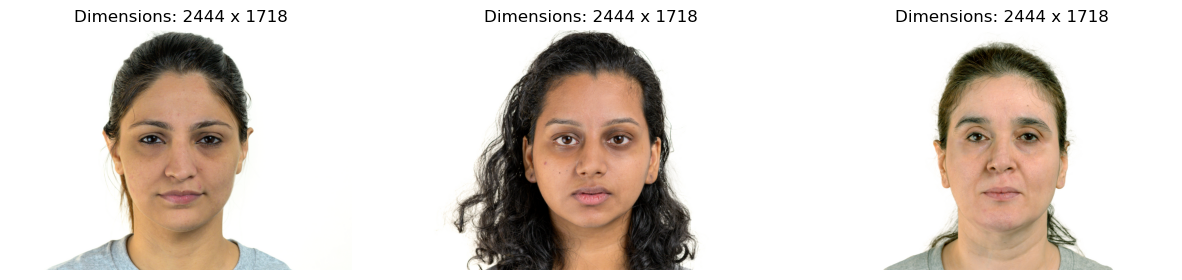

In [5]:
from PIL import Image
# Load the first 3 images
images = []
image_dims = []
for i in range(min(3, len(image_files))):
    img_path = os.path.join(extractPath, image_files[i])
    img = Image.open(img_path)
    images.append(img)
    image_dims.append(img.size)  # (width, height)

# Plot the first 3 images with their dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, dim in zip(axes, images, image_dims):
    ax.imshow(img)
    ax.set_title(f'Dimensions: {dim[0]} x {dim[1]}')
    ax.axis('off')

plt.show()

In [6]:
data_path = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\INDA\\'

# Define data generator for custom data
# Create an instance of the ImageDataGenerator with rescaling and zoom range
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(88, 120),
    batch_size=32,
    class_mode=None  # No labels required for GANs
)

Found 138 images belonging to 1 classes.


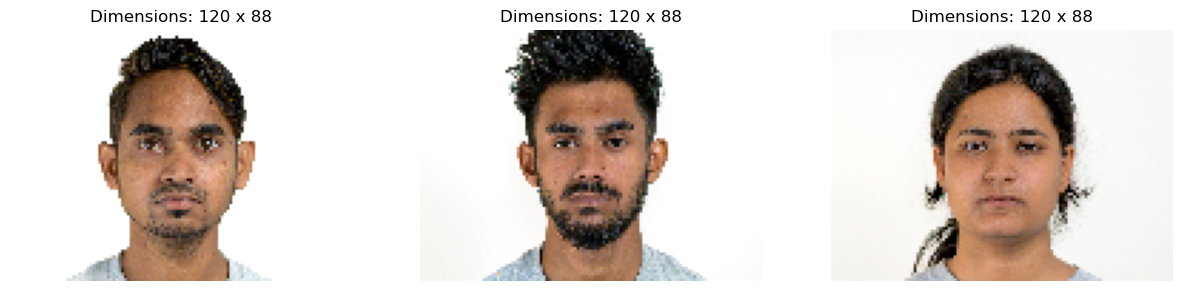

In [7]:
# Get the first batch of images
images_batch = next(train_generator)
first_three_images = images_batch[:3]

# Plot the first 3 images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img in zip(axes, first_three_images):
    ax.imshow(img)
    ax.set_title(f'Dimensions: 120 x 88')
    ax.axis('off')

plt.show()

## Generator-Discriminator

In [8]:
# Generator model
def build_generator():
    model = Sequential()
    model.add(Dense(256 * 15 * 11, activation='relu', input_dim=100))
    model.add(Reshape((11, 15, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    #model.summary()
    return model

In [9]:
# Discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(88, 120, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    return model

In [10]:
# Build and compile the discriminator
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\kaizi\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\kaizi\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Verify the models' output shapes
print("Generator output shape:", generator.output_shape)
print("Discriminator input shape:", discriminator.input_shape)

Generator output shape: (None, 88, 120, 3)
Discriminator input shape: (None, 88, 120, 3)


In [12]:
# GAN model (stacked generator and discriminator)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
gan = Model(z, validity)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


In [13]:
# Define constants
epochs = 5000
batch_size = 32
codings_size = 100
save_interval = 100

In [14]:
# Save generated images
def save_images(epoch, generator, examples=3, dim=(1, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale images 0 - 1
    
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.close()

In [15]:
def load_data(generator, batch_size):
    X = []
    for _ in range(batch_size):
        img = next(generator)
        X.append(img[0])
    X = np.array(X)
    return X

In [ ]:
# Training loop
for epoch in range(epochs):
    # Train Discriminator
    imgs = load_data(train_generator, batch_size)
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, valid)

    # Print progress
    print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # If at save interval, save generated image samples
    if epoch % save_interval == 0:
        save_images(epoch, generator, examples=3)

print("Training completed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


C:\Users\kaizi\anaconda3\lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7430800199508667 | D accuracy: 38.28125] [G loss: [array(0.72640544, dtype=float32), array(0.72640544, dtype=float32), array(0.453125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1 [D loss: 0.728360652923584 | D accuracy: 31.90104365348816] [G loss: [array(0.72356915, dtype=float32), array(0.72356915, dtype=float32), array(0.2734375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2 [D loss: 0.7296230792999268 | D accuracy: 24.062499403953552] [G loss: [array(0.7266354, dtype=float32), array(0.7266354, dtype=float32), array(0.21875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3 [D loss: 0.7300827503204346 | D accuracy: 19.67075914144516] [G loss: [array(0.7280231, dtype=float32), array(0.7280231, dtype=float32), array(0.18359375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4 [D loss: 0.732199490070343 | D accuracy: 17.152777314186096] [G loss: [array(0.73062074, dtype=float32), array(0.73062074,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
28 [D loss: 0.8445055484771729 | D accuracy: 11.087794601917267] [G loss: [array(0.84932715, dtype=float32), array(0.84932715, dtype=float32), array(0.1099138, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
29 [D loss: 0.8524811863899231 | D accuracy: 11.240289360284805] [G loss: [array(0.85697633, dtype=float32), array(0.85697633, dtype=float32), array(0.11145833, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
30 [D loss: 0.8601398468017578 | D accuracy: 11.027151346206665] [G loss: [array(0.864594, dtype=float32), array(0.864594, dtype=float32), array(0.109375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
31 [D loss: 0.8679132461547852 | D accuracy: 10.82744300365448] [G loss: [array(0.8723829, dtype=float32), array(0.8723829, dtype=float32), array(0.10742188, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32 [D loss: 0.8749476671218872 | D accuracy: 10.926209390163422] [G loss: [array(0.87927717, dtype=float32),

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
61 [D loss: 1.0231444835662842 | D accuracy: 10.248143970966339] [G loss: [array(1.0258968, dtype=float32), array(1.0258968, dtype=float32), array(0.10206653, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
62 [D loss: 1.0265427827835083 | D accuracy: 10.234226286411285] [G loss: [array(1.0294453, dtype=float32), array(1.0294453, dtype=float32), array(0.10193452, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
63 [D loss: 1.030062198638916 | D accuracy: 10.245256125926971] [G loss: [array(1.032861, dtype=float32), array(1.032861, dtype=float32), array(0.10205078, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
64 [D loss: 1.033632755279541 | D accuracy: 10.280075669288635] [G loss: [array(1.0364863, dtype=float32), array(1.0364863, dtype=float32), array(0.10240385, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
65 [D loss: 1.037261724472046 | D accuracy: 10.218778997659683] [G loss: [array(1.0401498, dtype=float32), arr

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
94 [D loss: 1.127478837966919 | D accuracy: 9.614183008670807] [G loss: [array(1.1298375, dtype=float32), array(1.1298375, dtype=float32), array(0.09588816, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
95 [D loss: 1.1302284002304077 | D accuracy: 9.579047560691833] [G loss: [array(1.1325644, dtype=float32), array(1.1325644, dtype=float32), array(0.09554037, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
96 [D loss: 1.1331877708435059 | D accuracy: 9.528487920761108] [G loss: [array(1.1355916, dtype=float32), array(1.1355916, dtype=float32), array(0.09503866, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
97 [D loss: 1.136030912399292 | D accuracy: 9.558886289596558] [G loss: [array(1.1383742, dtype=float32), array(1.1383742, dtype=float32), array(0.09534439, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
98 [D loss: 1.1387568712234497 | D accuracy: 9.54120010137558] [G loss: [array(1.1410491, dtype=float32), array(

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
127 [D loss: 1.2169246673583984 | D accuracy: 9.30776596069336] [G loss: [array(1.2192026, dtype=float32), array(1.2192026, dtype=float32), array(0.09289551, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
128 [D loss: 1.219757080078125 | D accuracy: 9.296151995658875] [G loss: [array(1.2220275, dtype=float32), array(1.2220275, dtype=float32), array(0.09278101, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
129 [D loss: 1.2224438190460205 | D accuracy: 9.2606320977211] [G loss: [array(1.2246048, dtype=float32), array(1.2246048, dtype=float32), array(0.09242789, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
130 [D loss: 1.2249938249588013 | D accuracy: 9.309306740760803] [G loss: [array(1.2272098, dtype=float32), array(1.2272098, dtype=float32), array(0.09291507, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
131 [D loss: 1.227798581123352 | D accuracy: 9.297946095466614] [G loss: [array(1.2301116, dtype=float32), arr

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
160 [D loss: 1.3078174591064453 | D accuracy: 9.311842173337936] [G loss: [array(1.30997, dtype=float32), array(1.30997, dtype=float32), array(0.0929736, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
161 [D loss: 1.3105530738830566 | D accuracy: 9.28325206041336] [G loss: [array(1.312778, dtype=float32), array(1.312778, dtype=float32), array(0.09268904, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
162 [D loss: 1.3132703304290771 | D accuracy: 9.293416142463684] [G loss: [array(1.3154281, dtype=float32), array(1.3154281, dtype=float32), array(0.09279141, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
163 [D loss: 1.3159053325653076 | D accuracy: 9.303456544876099] [G loss: [array(1.3181182, dtype=float32), array(1.3181182, dtype=float32), array(0.09289253, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
164 [D loss: 1.3185369968414307 | D accuracy: 9.322859346866608] [G loss: [array(1.3207107, dtype=float32), array(

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
193 [D loss: 1.3952993154525757 | D accuracy: 9.42743495106697] [G loss: [array(1.3974595, dtype=float32), array(1.3974595, dtype=float32), array(0.0941527, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
194 [D loss: 1.397857427597046 | D accuracy: 9.419143199920654] [G loss: [array(1.3998737, dtype=float32), array(1.3998737, dtype=float32), array(0.09407052, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
195 [D loss: 1.4002611637115479 | D accuracy: 9.418916702270508] [G loss: [array(1.4023052, dtype=float32), array(1.4023052, dtype=float32), array(0.09406888, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
196 [D loss: 1.4028432369232178 | D accuracy: 9.402810782194138] [G loss: [array(1.4049853, dtype=float32), array(1.4049853, dtype=float32), array(0.09390863, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
197 [D loss: 1.4053895473480225 | D accuracy: 9.402669966220856] [G loss: [array(1.4074216, dtype=float32), a

In [ ]:
def generate_and_save_images(generator, examples=9):
    noise = np.random.normal(0, 1, (examples, 100))
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(examples, 1, figsize=(10, 10))
    for i in range(examples):
        axs[i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.savefig("generated_images_after_training.png")
    plt.show()

In [ ]:
generate_and_save_images(generator, examples=9)

In [ ]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')
gan.save('gan_model.h5')